In [1]:
from Utils.batched_A2C_training import ParallelEnv
from AC_modules.Constructor import *
import torch
from Utils import test_env

In [2]:
def test(step_idx, agent, game_params):
    env = test_env.Sandbox(**game_params)
    score = 0.0
    done = False
    num_test = 10
    steps_to_solve = 0
    for _ in range(num_test):
        s = env.random_reset()
        rewards = []
        while not done:
            a, log_prob, probs = agent.get_action(s)
            s_prime, r, done, info = env.step(a[0])
            s = s_prime
            score += r
            rewards.append(r)
        done = False
        steps_to_solve += len(rewards)
    print(f"Step # :{step_idx}, avg score : {score/num_test:.1f}, avg steps to solve : {steps_to_solve/num_test}")
    return score/num_test, steps_to_solve/num_test

In [3]:
def train_batched_A2C(agent, game_params, lr, n_train_processes, max_train_steps, unroll_length, test_interval=100):
    envs = ParallelEnv(n_train_processes, game_params)

    optimizer = torch.optim.Adam(agent.parameters(), lr=lr)

    score = []
    steps_to_solve = []
    critic_losses = [] 
    actor_losses = []
    entropies = []
    
    step_idx = 0
    s = envs.reset()
    while step_idx < max_train_steps:
        s_lst, a_lst, r_lst, done_lst, bootstrap_lst, s_trg_lst = list(), list(), list(), list(), list(), list()
        log_probs = []
        distributions = []
        for _ in range(unroll_length):

            a, log_prob, probs = agent.get_action(s)
            a_lst.append(a)
            log_probs.append(log_prob)
            distributions.append(probs)

            s_prime, r, done, info, bootstrap, s_trg = envs.step(a)
            s_lst.append(s)
            r_lst.append(r)
            done_lst.append(done)
            bootstrap_lst.append(bootstrap)
            s_trg_lst.append(s_trg)

            s = s_prime
            step_idx += 1 #n_train_processes

        s_lst = np.array(s_lst).transpose(1,0,2,3,4)
        r_lst = np.array(r_lst).transpose(1,0)
        done_lst = np.array(done_lst).transpose(1,0)
        bootstrap_lst = np.array(bootstrap_lst).transpose(1,0)
        s_trg_lst = np.array(s_trg_lst).transpose(1,0,2,3,4)
        
        ### Update time ###
        #print("len(r_lst): ", r_lst.shape)
        #print("len(s_lst): ", s_lst.shape)
        #print("len(done_lst): ", done_lst.shape)
        #print("len(s_trg_lst): ", s_trg_lst.shape)
        critic_loss, actor_loss, entropy = agent.compute_ac_loss(r_lst, log_probs, distributions, 
                                                                 s_lst, done_lst, bootstrap_lst, s_trg_lst)

        loss = (critic_loss + actor_loss).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        #print("critic_loss: ", critic_loss)
        #print("actor_loss: ", actor_loss)
        #print("entropy: ", entropy)
        critic_losses.append(critic_loss.item())
        actor_losses.append(actor_loss.item())
        entropies.append(entropy.item())
        
        ### Test time ###
        if step_idx % test_interval == 0:
            avg_score, avg_steps = test(step_idx, agent, game_params)
            score.append(avg_score)
            steps_to_solve.append(avg_steps)
    envs.close()
    
    losses = dict(critic_losses=critic_losses, actor_losses=actor_losses, entropies=entropies)
    return score, steps_to_solve, losses, agent

In [4]:
# Variable parameters
X = 5
Y = 5
initial = [0,0]
goal = [4,4]
MAX_STEPS = 100

game_params = dict(x=X, y=Y, initial=initial, goal=goal, max_steps=MAX_STEPS, 
                   greyscale_state=True, return_ohe=True)

In [5]:
relational_HPs = torch.load("Results/Sandbox/Supervised/best_HP_S_chosen-residual_UMUT")
name = "GatedBoxWorldNet"
action_space = 4

HPs = dict(gamma=0.99, n_steps=5, H=1e-3, **relational_HPs)
lr = 1e-4
shared_architecture = True

if torch.cuda.is_available():
    HPs['device'] = 'cuda'
else:
    HPs['device'] = 'cpu'
    
print("Using device "+HPs['device'])
agent_constructor = BatchedA2CConstructor(name, shared_architecture, action_space, **HPs)
agent = agent_constructor.generate_model()

Using device cuda
Model:  <class 'AC_modules.Networks.GatedBoxWorldNet'>
self.model:  <class 'AC_modules.Networks.GatedBoxWorldNet'>
self.shared:  True
self.args:  (4,)
self.kwargs:  {'gamma': 0.99, 'n_steps': 5, 'H': 0.001, 'n_kernels': 36, 'n_features': 256, 'n_heads': 1, 'n_attn_modules': 2, 'feature_hidden_dim': 16, 'feature_n_residuals': 1, 'device': 'cuda'}


In [6]:
n_train_processes = 11
max_train_steps = 500000
unroll_length = MAX_STEPS 
test_interval = 100 

In [7]:
%%time
results = train_batched_A2C(agent, game_params, lr, n_train_processes, max_train_steps, unroll_length, test_interval)

Step # :100, avg score : 0.9, avg steps to solve : 35.5
Step # :200, avg score : 0.7, avg steps to solve : 66.0
Step # :300, avg score : 0.9, avg steps to solve : 48.4
Step # :400, avg score : 0.8, avg steps to solve : 41.4
Step # :500, avg score : 0.7, avg steps to solve : 62.5
Step # :600, avg score : 0.9, avg steps to solve : 47.5
Step # :700, avg score : 0.6, avg steps to solve : 65.0
Step # :800, avg score : 0.8, avg steps to solve : 40.0
Step # :900, avg score : 0.7, avg steps to solve : 55.1
Step # :1000, avg score : 0.6, avg steps to solve : 56.3
Step # :1100, avg score : 0.8, avg steps to solve : 38.6
Step # :1200, avg score : 0.7, avg steps to solve : 50.0
Step # :1300, avg score : 0.8, avg steps to solve : 34.6
Step # :1400, avg score : 0.8, avg steps to solve : 36.0
Step # :1500, avg score : 0.9, avg steps to solve : 46.0
Step # :1600, avg score : 1.0, avg steps to solve : 30.2
Step # :1700, avg score : 0.9, avg steps to solve : 29.4
Step # :1800, avg score : 0.9, avg steps

Step # :14500, avg score : 0.8, avg steps to solve : 46.1
Step # :14600, avg score : 1.0, avg steps to solve : 25.2
Step # :14700, avg score : 0.9, avg steps to solve : 41.1
Step # :14800, avg score : 0.9, avg steps to solve : 35.3
Step # :14900, avg score : 0.9, avg steps to solve : 40.5
Step # :15000, avg score : 1.0, avg steps to solve : 35.2
Step # :15100, avg score : 0.8, avg steps to solve : 42.7
Step # :15200, avg score : 0.8, avg steps to solve : 48.7
Step # :15300, avg score : 0.9, avg steps to solve : 38.4
Step # :15400, avg score : 1.0, avg steps to solve : 35.0
Step # :15500, avg score : 0.9, avg steps to solve : 41.8
Step # :15600, avg score : 0.7, avg steps to solve : 56.8
Step # :15700, avg score : 1.0, avg steps to solve : 38.6
Step # :15800, avg score : 0.7, avg steps to solve : 49.4
Step # :15900, avg score : 0.7, avg steps to solve : 48.6
Step # :16000, avg score : 0.9, avg steps to solve : 36.8
Step # :16100, avg score : 1.0, avg steps to solve : 22.9
Step # :16200,

Step # :28700, avg score : 0.6, avg steps to solve : 61.4
Step # :28800, avg score : 1.0, avg steps to solve : 41.2
Step # :28900, avg score : 0.7, avg steps to solve : 50.5
Step # :29000, avg score : 1.0, avg steps to solve : 35.1
Step # :29100, avg score : 0.8, avg steps to solve : 47.4
Step # :29200, avg score : 0.8, avg steps to solve : 52.3
Step # :29300, avg score : 0.9, avg steps to solve : 38.4
Step # :29400, avg score : 0.8, avg steps to solve : 40.1
Step # :29500, avg score : 0.8, avg steps to solve : 45.5
Step # :29600, avg score : 1.0, avg steps to solve : 34.6
Step # :29700, avg score : 0.7, avg steps to solve : 52.1
Step # :29800, avg score : 0.9, avg steps to solve : 39.2
Step # :29900, avg score : 0.9, avg steps to solve : 37.6
Step # :30000, avg score : 0.9, avg steps to solve : 36.4
Step # :30100, avg score : 0.8, avg steps to solve : 60.1
Step # :30200, avg score : 0.8, avg steps to solve : 47.4
Step # :30300, avg score : 0.8, avg steps to solve : 49.5
Step # :30400,

Step # :42900, avg score : 0.6, avg steps to solve : 56.3
Step # :43000, avg score : 0.7, avg steps to solve : 42.4
Step # :43100, avg score : 0.7, avg steps to solve : 55.4
Step # :43200, avg score : 0.8, avg steps to solve : 55.7
Step # :43300, avg score : 0.7, avg steps to solve : 59.2
Step # :43400, avg score : 0.8, avg steps to solve : 55.7
Step # :43500, avg score : 0.7, avg steps to solve : 50.6
Step # :43600, avg score : 1.0, avg steps to solve : 24.6
Step # :43700, avg score : 0.9, avg steps to solve : 38.1
Step # :43800, avg score : 0.8, avg steps to solve : 33.9
Step # :43900, avg score : 1.0, avg steps to solve : 37.9
Step # :44000, avg score : 0.8, avg steps to solve : 47.1
Step # :44100, avg score : 0.9, avg steps to solve : 31.1
Step # :44200, avg score : 1.0, avg steps to solve : 32.7
Step # :44300, avg score : 0.8, avg steps to solve : 39.5
Step # :44400, avg score : 0.9, avg steps to solve : 43.4
Step # :44500, avg score : 0.9, avg steps to solve : 39.8
Step # :44600,

Step # :57100, avg score : 0.8, avg steps to solve : 37.6
Step # :57200, avg score : 0.8, avg steps to solve : 46.6
Step # :57300, avg score : 0.9, avg steps to solve : 46.9
Step # :57400, avg score : 0.8, avg steps to solve : 52.8
Step # :57500, avg score : 0.6, avg steps to solve : 62.8
Step # :57600, avg score : 0.9, avg steps to solve : 40.2
Step # :57700, avg score : 1.0, avg steps to solve : 39.7
Step # :57800, avg score : 0.8, avg steps to solve : 46.8
Step # :57900, avg score : 0.9, avg steps to solve : 33.1
Step # :58000, avg score : 0.7, avg steps to solve : 43.7
Step # :58100, avg score : 0.8, avg steps to solve : 35.4
Step # :58200, avg score : 0.8, avg steps to solve : 39.6
Step # :58300, avg score : 1.0, avg steps to solve : 25.0
Step # :58400, avg score : 0.9, avg steps to solve : 32.9
Step # :58500, avg score : 0.9, avg steps to solve : 46.8
Step # :58600, avg score : 0.9, avg steps to solve : 44.3
Step # :58700, avg score : 0.9, avg steps to solve : 22.0
Step # :58800,

Step # :71300, avg score : 0.9, avg steps to solve : 18.8
Step # :71400, avg score : 1.0, avg steps to solve : 11.0
Step # :71500, avg score : 1.0, avg steps to solve : 4.5
Step # :71600, avg score : 0.9, avg steps to solve : 18.7
Step # :71700, avg score : 1.0, avg steps to solve : 6.4
Step # :71800, avg score : 1.0, avg steps to solve : 13.1
Step # :71900, avg score : 1.0, avg steps to solve : 7.6
Step # :72000, avg score : 1.0, avg steps to solve : 8.3
Step # :72100, avg score : 1.0, avg steps to solve : 6.6
Step # :72200, avg score : 1.0, avg steps to solve : 10.4
Step # :72300, avg score : 1.0, avg steps to solve : 6.2
Step # :72400, avg score : 1.0, avg steps to solve : 7.1
Step # :72500, avg score : 1.0, avg steps to solve : 5.9
Step # :72600, avg score : 1.0, avg steps to solve : 5.3
Step # :72700, avg score : 1.0, avg steps to solve : 6.4
Step # :72800, avg score : 1.0, avg steps to solve : 6.8
Step # :72900, avg score : 1.0, avg steps to solve : 9.2
Step # :73000, avg score :

Step # :85700, avg score : 1.0, avg steps to solve : 3.4
Step # :85800, avg score : 1.0, avg steps to solve : 3.6
Step # :85900, avg score : 1.0, avg steps to solve : 3.1
Step # :86000, avg score : 1.0, avg steps to solve : 3.2
Step # :86100, avg score : 1.0, avg steps to solve : 3.3
Step # :86200, avg score : 1.0, avg steps to solve : 3.5
Step # :86300, avg score : 1.0, avg steps to solve : 4.3
Step # :86400, avg score : 1.0, avg steps to solve : 3.5
Step # :86500, avg score : 1.0, avg steps to solve : 4.0
Step # :86600, avg score : 1.0, avg steps to solve : 3.3
Step # :86700, avg score : 1.0, avg steps to solve : 2.7
Step # :86800, avg score : 1.0, avg steps to solve : 3.2
Step # :86900, avg score : 1.0, avg steps to solve : 4.1
Step # :87000, avg score : 1.0, avg steps to solve : 2.4
Step # :87100, avg score : 1.0, avg steps to solve : 3.1
Step # :87200, avg score : 1.0, avg steps to solve : 3.8
Step # :87300, avg score : 1.0, avg steps to solve : 3.3
Step # :87400, avg score : 1.0,

Step # :100100, avg score : 1.0, avg steps to solve : 2.8
Step # :100200, avg score : 1.0, avg steps to solve : 3.8
Step # :100300, avg score : 1.0, avg steps to solve : 3.4
Step # :100400, avg score : 1.0, avg steps to solve : 3.9
Step # :100500, avg score : 1.0, avg steps to solve : 4.0
Step # :100600, avg score : 1.0, avg steps to solve : 2.9
Step # :100700, avg score : 1.0, avg steps to solve : 2.9
Step # :100800, avg score : 1.0, avg steps to solve : 3.7
Step # :100900, avg score : 1.0, avg steps to solve : 3.8
Step # :101000, avg score : 1.0, avg steps to solve : 3.4
Step # :101100, avg score : 1.0, avg steps to solve : 2.8
Step # :101200, avg score : 1.0, avg steps to solve : 2.6
Step # :101300, avg score : 1.0, avg steps to solve : 2.7
Step # :101400, avg score : 1.0, avg steps to solve : 2.8
Step # :101500, avg score : 1.0, avg steps to solve : 2.8
Step # :101600, avg score : 1.0, avg steps to solve : 3.3
Step # :101700, avg score : 1.0, avg steps to solve : 3.4
Step # :101800

Step # :114300, avg score : 1.0, avg steps to solve : 3.0
Step # :114400, avg score : 1.0, avg steps to solve : 4.2
Step # :114500, avg score : 1.0, avg steps to solve : 2.9
Step # :114600, avg score : 1.0, avg steps to solve : 3.9
Step # :114700, avg score : 1.0, avg steps to solve : 3.4
Step # :114800, avg score : 1.0, avg steps to solve : 3.7
Step # :114900, avg score : 1.0, avg steps to solve : 3.8
Step # :115000, avg score : 1.0, avg steps to solve : 4.1
Step # :115100, avg score : 1.0, avg steps to solve : 2.9
Step # :115200, avg score : 1.0, avg steps to solve : 3.0
Step # :115300, avg score : 1.0, avg steps to solve : 3.8
Step # :115400, avg score : 1.0, avg steps to solve : 3.5
Step # :115500, avg score : 1.0, avg steps to solve : 3.0
Step # :115600, avg score : 1.0, avg steps to solve : 3.8
Step # :115700, avg score : 1.0, avg steps to solve : 3.5
Step # :115800, avg score : 1.0, avg steps to solve : 3.2
Step # :115900, avg score : 1.0, avg steps to solve : 3.1
Step # :116000

Step # :128500, avg score : 1.0, avg steps to solve : 2.7
Step # :128600, avg score : 1.0, avg steps to solve : 3.6
Step # :128700, avg score : 1.0, avg steps to solve : 3.8
Step # :128800, avg score : 1.0, avg steps to solve : 3.7
Step # :128900, avg score : 1.0, avg steps to solve : 3.6
Step # :129000, avg score : 1.0, avg steps to solve : 3.5
Step # :129100, avg score : 1.0, avg steps to solve : 3.6
Step # :129200, avg score : 1.0, avg steps to solve : 2.9
Step # :129300, avg score : 1.0, avg steps to solve : 3.9
Step # :129400, avg score : 1.0, avg steps to solve : 3.3
Step # :129500, avg score : 1.0, avg steps to solve : 2.2
Step # :129600, avg score : 1.0, avg steps to solve : 3.5
Step # :129700, avg score : 1.0, avg steps to solve : 3.5
Step # :129800, avg score : 1.0, avg steps to solve : 3.3
Step # :129900, avg score : 1.0, avg steps to solve : 3.5
Step # :130000, avg score : 1.0, avg steps to solve : 2.8
Step # :130100, avg score : 1.0, avg steps to solve : 3.2
Step # :130200

Step # :142700, avg score : 1.0, avg steps to solve : 3.9
Step # :142800, avg score : 1.0, avg steps to solve : 3.0
Step # :142900, avg score : 1.0, avg steps to solve : 2.7
Step # :143000, avg score : 1.0, avg steps to solve : 3.3
Step # :143100, avg score : 1.0, avg steps to solve : 3.5
Step # :143200, avg score : 1.0, avg steps to solve : 3.4
Step # :143300, avg score : 1.0, avg steps to solve : 4.1
Step # :143400, avg score : 1.0, avg steps to solve : 3.4
Step # :143500, avg score : 1.0, avg steps to solve : 4.5
Step # :143600, avg score : 1.0, avg steps to solve : 3.7
Step # :143700, avg score : 1.0, avg steps to solve : 3.8
Step # :143800, avg score : 1.0, avg steps to solve : 3.8
Step # :143900, avg score : 1.0, avg steps to solve : 3.3
Step # :144000, avg score : 1.0, avg steps to solve : 3.4
Step # :144100, avg score : 1.0, avg steps to solve : 3.2
Step # :144200, avg score : 1.0, avg steps to solve : 3.9
Step # :144300, avg score : 1.0, avg steps to solve : 3.9
Step # :144400

Step # :156900, avg score : 1.0, avg steps to solve : 3.8
Step # :157000, avg score : 1.0, avg steps to solve : 3.4
Step # :157100, avg score : 1.0, avg steps to solve : 2.9
Step # :157200, avg score : 1.0, avg steps to solve : 3.7
Step # :157300, avg score : 1.0, avg steps to solve : 3.2
Step # :157400, avg score : 1.0, avg steps to solve : 4.1
Step # :157500, avg score : 1.0, avg steps to solve : 2.8
Step # :157600, avg score : 1.0, avg steps to solve : 4.2
Step # :157700, avg score : 1.0, avg steps to solve : 3.1
Step # :157800, avg score : 1.0, avg steps to solve : 4.1
Step # :157900, avg score : 1.0, avg steps to solve : 3.6
Step # :158000, avg score : 1.0, avg steps to solve : 3.6
Step # :158100, avg score : 1.0, avg steps to solve : 3.8
Step # :158200, avg score : 1.0, avg steps to solve : 3.4
Step # :158300, avg score : 1.0, avg steps to solve : 3.8
Step # :158400, avg score : 1.0, avg steps to solve : 2.7
Step # :158500, avg score : 1.0, avg steps to solve : 3.0
Step # :158600

Step # :171100, avg score : 1.0, avg steps to solve : 3.7
Step # :171200, avg score : 1.0, avg steps to solve : 3.5
Step # :171300, avg score : 1.0, avg steps to solve : 4.1
Step # :171400, avg score : 1.0, avg steps to solve : 2.4
Step # :171500, avg score : 1.0, avg steps to solve : 3.0
Step # :171600, avg score : 1.0, avg steps to solve : 3.5
Step # :171700, avg score : 1.0, avg steps to solve : 3.7
Step # :171800, avg score : 1.0, avg steps to solve : 3.5
Step # :171900, avg score : 1.0, avg steps to solve : 3.3
Step # :172000, avg score : 1.0, avg steps to solve : 2.8
Step # :172100, avg score : 1.0, avg steps to solve : 3.3
Step # :172200, avg score : 1.0, avg steps to solve : 3.4
Step # :172300, avg score : 1.0, avg steps to solve : 3.2
Step # :172400, avg score : 1.0, avg steps to solve : 3.4
Step # :172500, avg score : 1.0, avg steps to solve : 3.2
Step # :172600, avg score : 1.0, avg steps to solve : 3.2
Step # :172700, avg score : 1.0, avg steps to solve : 4.1
Step # :172800

Step # :185300, avg score : 1.0, avg steps to solve : 2.8
Step # :185400, avg score : 1.0, avg steps to solve : 4.1
Step # :185500, avg score : 1.0, avg steps to solve : 3.0
Step # :185600, avg score : 1.0, avg steps to solve : 3.6
Step # :185700, avg score : 1.0, avg steps to solve : 2.9
Step # :185800, avg score : 1.0, avg steps to solve : 3.8
Step # :185900, avg score : 1.0, avg steps to solve : 3.4
Step # :186000, avg score : 1.0, avg steps to solve : 3.0
Step # :186100, avg score : 1.0, avg steps to solve : 3.3
Step # :186200, avg score : 1.0, avg steps to solve : 2.8
Step # :186300, avg score : 1.0, avg steps to solve : 3.6
Step # :186400, avg score : 1.0, avg steps to solve : 3.0
Step # :186500, avg score : 1.0, avg steps to solve : 3.4
Step # :186600, avg score : 1.0, avg steps to solve : 3.1
Step # :186700, avg score : 1.0, avg steps to solve : 3.9
Step # :186800, avg score : 1.0, avg steps to solve : 3.1
Step # :186900, avg score : 1.0, avg steps to solve : 3.3
Step # :187000

Step # :199500, avg score : 1.0, avg steps to solve : 3.2
Step # :199600, avg score : 1.0, avg steps to solve : 3.3
Step # :199700, avg score : 1.0, avg steps to solve : 3.2
Step # :199800, avg score : 1.0, avg steps to solve : 3.1
Step # :199900, avg score : 1.0, avg steps to solve : 4.7
Step # :200000, avg score : 1.0, avg steps to solve : 3.8
Step # :200100, avg score : 1.0, avg steps to solve : 3.3
Step # :200200, avg score : 1.0, avg steps to solve : 2.6
Step # :200300, avg score : 1.0, avg steps to solve : 3.4
Step # :200400, avg score : 1.0, avg steps to solve : 3.2
Step # :200500, avg score : 1.0, avg steps to solve : 2.9
Step # :200600, avg score : 1.0, avg steps to solve : 3.4
Step # :200700, avg score : 1.0, avg steps to solve : 2.9
Step # :200800, avg score : 1.0, avg steps to solve : 3.0
Step # :200900, avg score : 1.0, avg steps to solve : 4.1
Step # :201000, avg score : 1.0, avg steps to solve : 2.7
Step # :201100, avg score : 1.0, avg steps to solve : 3.2
Step # :201200

Step # :213700, avg score : 1.0, avg steps to solve : 3.6
Step # :213800, avg score : 1.0, avg steps to solve : 3.0
Step # :213900, avg score : 1.0, avg steps to solve : 2.9
Step # :214000, avg score : 1.0, avg steps to solve : 2.8
Step # :214100, avg score : 1.0, avg steps to solve : 3.6
Step # :214200, avg score : 1.0, avg steps to solve : 3.0
Step # :214300, avg score : 1.0, avg steps to solve : 3.9
Step # :214400, avg score : 1.0, avg steps to solve : 3.6
Step # :214500, avg score : 1.0, avg steps to solve : 4.0
Step # :214600, avg score : 1.0, avg steps to solve : 3.1
Step # :214700, avg score : 1.0, avg steps to solve : 3.0
Step # :214800, avg score : 1.0, avg steps to solve : 2.7
Step # :214900, avg score : 1.0, avg steps to solve : 3.6
Step # :215000, avg score : 1.0, avg steps to solve : 3.1
Step # :215100, avg score : 1.0, avg steps to solve : 3.3
Step # :215200, avg score : 1.0, avg steps to solve : 3.4
Step # :215300, avg score : 1.0, avg steps to solve : 3.7
Step # :215400

Step # :227900, avg score : 1.0, avg steps to solve : 3.0
Step # :228000, avg score : 1.0, avg steps to solve : 4.1
Step # :228100, avg score : 1.0, avg steps to solve : 3.4
Step # :228200, avg score : 1.0, avg steps to solve : 2.7
Step # :228300, avg score : 1.0, avg steps to solve : 3.2
Step # :228400, avg score : 1.0, avg steps to solve : 3.8
Step # :228500, avg score : 1.0, avg steps to solve : 3.7
Step # :228600, avg score : 1.0, avg steps to solve : 2.8
Step # :228700, avg score : 1.0, avg steps to solve : 3.7
Step # :228800, avg score : 1.0, avg steps to solve : 2.3
Step # :228900, avg score : 1.0, avg steps to solve : 3.7
Step # :229000, avg score : 1.0, avg steps to solve : 3.4
Step # :229100, avg score : 1.0, avg steps to solve : 3.5
Step # :229200, avg score : 1.0, avg steps to solve : 3.0
Step # :229300, avg score : 1.0, avg steps to solve : 3.1
Step # :229400, avg score : 1.0, avg steps to solve : 3.2
Step # :229500, avg score : 1.0, avg steps to solve : 3.5
Step # :229600

Step # :242100, avg score : 1.0, avg steps to solve : 3.9
Step # :242200, avg score : 1.0, avg steps to solve : 3.8
Step # :242300, avg score : 1.0, avg steps to solve : 3.3
Step # :242400, avg score : 1.0, avg steps to solve : 3.2
Step # :242500, avg score : 1.0, avg steps to solve : 3.7
Step # :242600, avg score : 1.0, avg steps to solve : 3.1
Step # :242700, avg score : 1.0, avg steps to solve : 3.6
Step # :242800, avg score : 1.0, avg steps to solve : 2.7
Step # :242900, avg score : 1.0, avg steps to solve : 3.7
Step # :243000, avg score : 1.0, avg steps to solve : 3.4
Step # :243100, avg score : 1.0, avg steps to solve : 4.0
Step # :243200, avg score : 1.0, avg steps to solve : 3.0
Step # :243300, avg score : 1.0, avg steps to solve : 3.4
Step # :243400, avg score : 1.0, avg steps to solve : 2.5
Step # :243500, avg score : 1.0, avg steps to solve : 3.2
Step # :243600, avg score : 1.0, avg steps to solve : 4.1
Step # :243700, avg score : 1.0, avg steps to solve : 3.5
Step # :243800

Step # :256300, avg score : 1.0, avg steps to solve : 3.0
Step # :256400, avg score : 1.0, avg steps to solve : 4.0
Step # :256500, avg score : 1.0, avg steps to solve : 3.5
Step # :256600, avg score : 1.0, avg steps to solve : 3.9
Step # :256700, avg score : 1.0, avg steps to solve : 3.3
Step # :256800, avg score : 1.0, avg steps to solve : 3.5
Step # :256900, avg score : 1.0, avg steps to solve : 2.4
Step # :257000, avg score : 1.0, avg steps to solve : 2.7
Step # :257100, avg score : 1.0, avg steps to solve : 3.7
Step # :257200, avg score : 1.0, avg steps to solve : 3.4
Step # :257300, avg score : 1.0, avg steps to solve : 2.7
Step # :257400, avg score : 1.0, avg steps to solve : 3.8
Step # :257500, avg score : 1.0, avg steps to solve : 3.6
Step # :257600, avg score : 1.0, avg steps to solve : 3.1
Step # :257700, avg score : 1.0, avg steps to solve : 3.2
Step # :257800, avg score : 1.0, avg steps to solve : 3.0
Step # :257900, avg score : 1.0, avg steps to solve : 3.4
Step # :258000

Step # :270500, avg score : 1.0, avg steps to solve : 4.2
Step # :270600, avg score : 1.0, avg steps to solve : 3.1
Step # :270700, avg score : 1.0, avg steps to solve : 3.7
Step # :270800, avg score : 1.0, avg steps to solve : 3.8
Step # :270900, avg score : 1.0, avg steps to solve : 4.0
Step # :271000, avg score : 1.0, avg steps to solve : 4.2
Step # :271100, avg score : 1.0, avg steps to solve : 2.3
Step # :271200, avg score : 1.0, avg steps to solve : 2.9
Step # :271300, avg score : 1.0, avg steps to solve : 3.4
Step # :271400, avg score : 1.0, avg steps to solve : 3.3
Step # :271500, avg score : 1.0, avg steps to solve : 3.2
Step # :271600, avg score : 1.0, avg steps to solve : 3.7
Step # :271700, avg score : 1.0, avg steps to solve : 2.9
Step # :271800, avg score : 1.0, avg steps to solve : 3.0
Step # :271900, avg score : 1.0, avg steps to solve : 3.0
Step # :272000, avg score : 1.0, avg steps to solve : 3.1
Step # :272100, avg score : 1.0, avg steps to solve : 3.4
Step # :272200

Step # :284700, avg score : 1.0, avg steps to solve : 3.3
Step # :284800, avg score : 1.0, avg steps to solve : 4.4
Step # :284900, avg score : 1.0, avg steps to solve : 3.4
Step # :285000, avg score : 1.0, avg steps to solve : 4.0
Step # :285100, avg score : 1.0, avg steps to solve : 3.6
Step # :285200, avg score : 1.0, avg steps to solve : 3.1
Step # :285300, avg score : 1.0, avg steps to solve : 2.6
Step # :285400, avg score : 1.0, avg steps to solve : 3.5
Step # :285500, avg score : 1.0, avg steps to solve : 2.8
Step # :285600, avg score : 1.0, avg steps to solve : 3.3
Step # :285700, avg score : 1.0, avg steps to solve : 2.8
Step # :285800, avg score : 1.0, avg steps to solve : 3.0
Step # :285900, avg score : 1.0, avg steps to solve : 3.9
Step # :286000, avg score : 1.0, avg steps to solve : 3.1
Step # :286100, avg score : 1.0, avg steps to solve : 3.1
Step # :286200, avg score : 1.0, avg steps to solve : 3.8
Step # :286300, avg score : 1.0, avg steps to solve : 3.9
Step # :286400

Step # :298900, avg score : 1.0, avg steps to solve : 4.3
Step # :299000, avg score : 1.0, avg steps to solve : 3.1
Step # :299100, avg score : 1.0, avg steps to solve : 3.1
Step # :299200, avg score : 1.0, avg steps to solve : 3.6
Step # :299300, avg score : 1.0, avg steps to solve : 3.5
Step # :299400, avg score : 1.0, avg steps to solve : 3.4
Step # :299500, avg score : 1.0, avg steps to solve : 3.6
Step # :299600, avg score : 1.0, avg steps to solve : 2.9
Step # :299700, avg score : 1.0, avg steps to solve : 2.8
Step # :299800, avg score : 1.0, avg steps to solve : 3.9
Step # :299900, avg score : 1.0, avg steps to solve : 3.3
Step # :300000, avg score : 1.0, avg steps to solve : 3.0
Step # :300100, avg score : 1.0, avg steps to solve : 2.9
Step # :300200, avg score : 1.0, avg steps to solve : 2.6
Step # :300300, avg score : 1.0, avg steps to solve : 3.4
Step # :300400, avg score : 1.0, avg steps to solve : 3.9
Step # :300500, avg score : 1.0, avg steps to solve : 4.0
Step # :300600

Step # :313100, avg score : 1.0, avg steps to solve : 3.0
Step # :313200, avg score : 1.0, avg steps to solve : 4.2
Step # :313300, avg score : 1.0, avg steps to solve : 3.0
Step # :313400, avg score : 1.0, avg steps to solve : 2.8
Step # :313500, avg score : 1.0, avg steps to solve : 2.8
Step # :313600, avg score : 1.0, avg steps to solve : 3.4
Step # :313700, avg score : 1.0, avg steps to solve : 3.4
Step # :313800, avg score : 1.0, avg steps to solve : 3.1
Step # :313900, avg score : 1.0, avg steps to solve : 3.1
Step # :314000, avg score : 1.0, avg steps to solve : 3.9
Step # :314100, avg score : 1.0, avg steps to solve : 3.7
Step # :314200, avg score : 1.0, avg steps to solve : 3.4
Step # :314300, avg score : 1.0, avg steps to solve : 3.6
Step # :314400, avg score : 1.0, avg steps to solve : 3.0
Step # :314500, avg score : 1.0, avg steps to solve : 3.4
Step # :314600, avg score : 1.0, avg steps to solve : 3.6
Step # :314700, avg score : 1.0, avg steps to solve : 3.0
Step # :314800

Step # :327300, avg score : 1.0, avg steps to solve : 4.5
Step # :327400, avg score : 1.0, avg steps to solve : 3.8
Step # :327500, avg score : 1.0, avg steps to solve : 2.9
Step # :327600, avg score : 1.0, avg steps to solve : 3.7
Step # :327700, avg score : 1.0, avg steps to solve : 3.0
Step # :327800, avg score : 1.0, avg steps to solve : 2.9
Step # :327900, avg score : 1.0, avg steps to solve : 3.5
Step # :328000, avg score : 1.0, avg steps to solve : 4.0
Step # :328100, avg score : 1.0, avg steps to solve : 3.9
Step # :328200, avg score : 1.0, avg steps to solve : 3.3
Step # :328300, avg score : 1.0, avg steps to solve : 3.6
Step # :328400, avg score : 1.0, avg steps to solve : 3.8
Step # :328500, avg score : 1.0, avg steps to solve : 3.1
Step # :328600, avg score : 1.0, avg steps to solve : 3.1
Step # :328700, avg score : 1.0, avg steps to solve : 3.4
Step # :328800, avg score : 1.0, avg steps to solve : 2.7
Step # :328900, avg score : 1.0, avg steps to solve : 3.6
Step # :329000

Step # :341500, avg score : 1.0, avg steps to solve : 3.1
Step # :341600, avg score : 1.0, avg steps to solve : 2.1
Step # :341700, avg score : 1.0, avg steps to solve : 4.2
Step # :341800, avg score : 1.0, avg steps to solve : 2.2
Step # :341900, avg score : 1.0, avg steps to solve : 2.7
Step # :342000, avg score : 1.0, avg steps to solve : 2.8
Step # :342100, avg score : 1.0, avg steps to solve : 3.2
Step # :342200, avg score : 1.0, avg steps to solve : 2.7
Step # :342300, avg score : 1.0, avg steps to solve : 2.8
Step # :342400, avg score : 1.0, avg steps to solve : 3.3
Step # :342500, avg score : 1.0, avg steps to solve : 3.2
Step # :342600, avg score : 1.0, avg steps to solve : 2.6
Step # :342700, avg score : 1.0, avg steps to solve : 3.0
Step # :342800, avg score : 1.0, avg steps to solve : 3.2
Step # :342900, avg score : 1.0, avg steps to solve : 3.3
Step # :343000, avg score : 1.0, avg steps to solve : 3.2
Step # :343100, avg score : 1.0, avg steps to solve : 2.9
Step # :343200

Step # :355700, avg score : 1.0, avg steps to solve : 2.6
Step # :355800, avg score : 1.0, avg steps to solve : 3.0
Step # :355900, avg score : 1.0, avg steps to solve : 4.4
Step # :356000, avg score : 1.0, avg steps to solve : 3.6
Step # :356100, avg score : 1.0, avg steps to solve : 3.3
Step # :356200, avg score : 1.0, avg steps to solve : 3.9
Step # :356300, avg score : 1.0, avg steps to solve : 2.7
Step # :356400, avg score : 1.0, avg steps to solve : 3.5
Step # :356500, avg score : 1.0, avg steps to solve : 2.9
Step # :356600, avg score : 1.0, avg steps to solve : 4.8
Step # :356700, avg score : 1.0, avg steps to solve : 3.4
Step # :356800, avg score : 1.0, avg steps to solve : 3.4
Step # :356900, avg score : 1.0, avg steps to solve : 2.4
Step # :357000, avg score : 1.0, avg steps to solve : 3.2
Step # :357100, avg score : 1.0, avg steps to solve : 3.0
Step # :357200, avg score : 1.0, avg steps to solve : 3.1
Step # :357300, avg score : 1.0, avg steps to solve : 3.7
Step # :357400

Step # :369900, avg score : 1.0, avg steps to solve : 3.7
Step # :370000, avg score : 1.0, avg steps to solve : 3.6
Step # :370100, avg score : 1.0, avg steps to solve : 3.6
Step # :370200, avg score : 1.0, avg steps to solve : 2.9
Step # :370300, avg score : 1.0, avg steps to solve : 3.6
Step # :370400, avg score : 1.0, avg steps to solve : 2.7
Step # :370500, avg score : 1.0, avg steps to solve : 3.2
Step # :370600, avg score : 1.0, avg steps to solve : 4.5
Step # :370700, avg score : 1.0, avg steps to solve : 3.2
Step # :370800, avg score : 1.0, avg steps to solve : 2.5
Step # :370900, avg score : 1.0, avg steps to solve : 3.1
Step # :371000, avg score : 1.0, avg steps to solve : 2.7
Step # :371100, avg score : 1.0, avg steps to solve : 3.8
Step # :371200, avg score : 1.0, avg steps to solve : 4.2
Step # :371300, avg score : 1.0, avg steps to solve : 3.5
Step # :371400, avg score : 1.0, avg steps to solve : 2.3
Step # :371500, avg score : 1.0, avg steps to solve : 3.0
Step # :371600

Step # :384100, avg score : 1.0, avg steps to solve : 3.0
Step # :384200, avg score : 1.0, avg steps to solve : 3.8
Step # :384300, avg score : 1.0, avg steps to solve : 4.7
Step # :384400, avg score : 1.0, avg steps to solve : 3.6
Step # :384500, avg score : 1.0, avg steps to solve : 3.9
Step # :384600, avg score : 1.0, avg steps to solve : 3.0
Step # :384700, avg score : 1.0, avg steps to solve : 3.9
Step # :384800, avg score : 1.0, avg steps to solve : 3.2
Step # :384900, avg score : 1.0, avg steps to solve : 3.7
Step # :385000, avg score : 1.0, avg steps to solve : 3.4
Step # :385100, avg score : 1.0, avg steps to solve : 3.0
Step # :385200, avg score : 1.0, avg steps to solve : 3.7
Step # :385300, avg score : 1.0, avg steps to solve : 3.1
Step # :385400, avg score : 1.0, avg steps to solve : 4.6
Step # :385500, avg score : 1.0, avg steps to solve : 3.4
Step # :385600, avg score : 1.0, avg steps to solve : 3.0
Step # :385700, avg score : 1.0, avg steps to solve : 3.0
Step # :385800

Step # :398300, avg score : 1.0, avg steps to solve : 2.4
Step # :398400, avg score : 1.0, avg steps to solve : 3.6
Step # :398500, avg score : 1.0, avg steps to solve : 3.9
Step # :398600, avg score : 1.0, avg steps to solve : 3.0
Step # :398700, avg score : 1.0, avg steps to solve : 3.4
Step # :398800, avg score : 1.0, avg steps to solve : 2.8
Step # :398900, avg score : 1.0, avg steps to solve : 3.3
Step # :399000, avg score : 1.0, avg steps to solve : 3.2
Step # :399100, avg score : 1.0, avg steps to solve : 3.4
Step # :399200, avg score : 1.0, avg steps to solve : 2.8
Step # :399300, avg score : 1.0, avg steps to solve : 2.6
Step # :399400, avg score : 1.0, avg steps to solve : 4.0
Step # :399500, avg score : 1.0, avg steps to solve : 2.6
Step # :399600, avg score : 1.0, avg steps to solve : 2.9
Step # :399700, avg score : 1.0, avg steps to solve : 3.1
Step # :399800, avg score : 1.0, avg steps to solve : 3.3
Step # :399900, avg score : 1.0, avg steps to solve : 4.0
Step # :400000

Step # :412500, avg score : 1.0, avg steps to solve : 4.0
Step # :412600, avg score : 1.0, avg steps to solve : 2.9
Step # :412700, avg score : 1.0, avg steps to solve : 2.8
Step # :412800, avg score : 1.0, avg steps to solve : 3.1
Step # :412900, avg score : 1.0, avg steps to solve : 3.7
Step # :413000, avg score : 1.0, avg steps to solve : 3.5
Step # :413100, avg score : 1.0, avg steps to solve : 3.2
Step # :413200, avg score : 1.0, avg steps to solve : 2.8
Step # :413300, avg score : 1.0, avg steps to solve : 3.1
Step # :413400, avg score : 1.0, avg steps to solve : 3.3
Step # :413500, avg score : 1.0, avg steps to solve : 2.4
Step # :413600, avg score : 1.0, avg steps to solve : 3.0
Step # :413700, avg score : 1.0, avg steps to solve : 3.8
Step # :413800, avg score : 1.0, avg steps to solve : 3.8
Step # :413900, avg score : 1.0, avg steps to solve : 2.8
Step # :414000, avg score : 1.0, avg steps to solve : 2.5
Step # :414100, avg score : 1.0, avg steps to solve : 3.9
Step # :414200

Step # :426700, avg score : 1.0, avg steps to solve : 2.3
Step # :426800, avg score : 1.0, avg steps to solve : 3.7
Step # :426900, avg score : 1.0, avg steps to solve : 3.2
Step # :427000, avg score : 1.0, avg steps to solve : 3.8
Step # :427100, avg score : 1.0, avg steps to solve : 3.5
Step # :427200, avg score : 1.0, avg steps to solve : 2.8
Step # :427300, avg score : 1.0, avg steps to solve : 3.4
Step # :427400, avg score : 1.0, avg steps to solve : 3.1
Step # :427500, avg score : 1.0, avg steps to solve : 2.7
Step # :427600, avg score : 1.0, avg steps to solve : 3.3
Step # :427700, avg score : 1.0, avg steps to solve : 2.9
Step # :427800, avg score : 1.0, avg steps to solve : 3.2
Step # :427900, avg score : 1.0, avg steps to solve : 3.5
Step # :428000, avg score : 1.0, avg steps to solve : 2.7
Step # :428100, avg score : 1.0, avg steps to solve : 3.5
Step # :428200, avg score : 1.0, avg steps to solve : 4.1
Step # :428300, avg score : 1.0, avg steps to solve : 3.5
Step # :428400

Step # :440900, avg score : 1.0, avg steps to solve : 3.1
Step # :441000, avg score : 1.0, avg steps to solve : 3.0
Step # :441100, avg score : 1.0, avg steps to solve : 3.3
Step # :441200, avg score : 1.0, avg steps to solve : 3.1
Step # :441300, avg score : 1.0, avg steps to solve : 2.8
Step # :441400, avg score : 1.0, avg steps to solve : 2.9
Step # :441500, avg score : 1.0, avg steps to solve : 3.1
Step # :441600, avg score : 1.0, avg steps to solve : 3.9
Step # :441700, avg score : 1.0, avg steps to solve : 3.6
Step # :441800, avg score : 1.0, avg steps to solve : 3.6
Step # :441900, avg score : 1.0, avg steps to solve : 3.0
Step # :442000, avg score : 1.0, avg steps to solve : 2.9
Step # :442100, avg score : 1.0, avg steps to solve : 3.9
Step # :442200, avg score : 1.0, avg steps to solve : 3.4
Step # :442300, avg score : 1.0, avg steps to solve : 3.3
Step # :442400, avg score : 1.0, avg steps to solve : 3.9
Step # :442500, avg score : 1.0, avg steps to solve : 3.6
Step # :442600

Step # :455100, avg score : 1.0, avg steps to solve : 3.8
Step # :455200, avg score : 1.0, avg steps to solve : 3.3
Step # :455300, avg score : 1.0, avg steps to solve : 3.4
Step # :455400, avg score : 1.0, avg steps to solve : 3.3
Step # :455500, avg score : 1.0, avg steps to solve : 3.0
Step # :455600, avg score : 1.0, avg steps to solve : 3.0
Step # :455700, avg score : 1.0, avg steps to solve : 3.5
Step # :455800, avg score : 1.0, avg steps to solve : 2.9
Step # :455900, avg score : 1.0, avg steps to solve : 2.1
Step # :456000, avg score : 1.0, avg steps to solve : 2.6
Step # :456100, avg score : 1.0, avg steps to solve : 2.8
Step # :456200, avg score : 1.0, avg steps to solve : 3.7
Step # :456300, avg score : 1.0, avg steps to solve : 3.3
Step # :456400, avg score : 1.0, avg steps to solve : 3.5
Step # :456500, avg score : 1.0, avg steps to solve : 2.9
Step # :456600, avg score : 1.0, avg steps to solve : 3.4
Step # :456700, avg score : 1.0, avg steps to solve : 3.2
Step # :456800

Step # :469300, avg score : 1.0, avg steps to solve : 3.5
Step # :469400, avg score : 1.0, avg steps to solve : 3.4
Step # :469500, avg score : 1.0, avg steps to solve : 4.0
Step # :469600, avg score : 1.0, avg steps to solve : 3.6
Step # :469700, avg score : 1.0, avg steps to solve : 3.0
Step # :469800, avg score : 1.0, avg steps to solve : 3.9
Step # :469900, avg score : 1.0, avg steps to solve : 3.6
Step # :470000, avg score : 1.0, avg steps to solve : 2.7
Step # :470100, avg score : 1.0, avg steps to solve : 2.8
Step # :470200, avg score : 1.0, avg steps to solve : 3.6
Step # :470300, avg score : 1.0, avg steps to solve : 3.8
Step # :470400, avg score : 1.0, avg steps to solve : 2.8
Step # :470500, avg score : 1.0, avg steps to solve : 3.9
Step # :470600, avg score : 1.0, avg steps to solve : 3.1
Step # :470700, avg score : 1.0, avg steps to solve : 3.9
Step # :470800, avg score : 1.0, avg steps to solve : 3.4
Step # :470900, avg score : 1.0, avg steps to solve : 2.7
Step # :471000

Step # :483500, avg score : 1.0, avg steps to solve : 3.4
Step # :483600, avg score : 1.0, avg steps to solve : 2.7
Step # :483700, avg score : 1.0, avg steps to solve : 3.8
Step # :483800, avg score : 1.0, avg steps to solve : 3.2
Step # :483900, avg score : 1.0, avg steps to solve : 3.1
Step # :484000, avg score : 1.0, avg steps to solve : 2.8
Step # :484100, avg score : 1.0, avg steps to solve : 3.0
Step # :484200, avg score : 1.0, avg steps to solve : 3.1
Step # :484300, avg score : 1.0, avg steps to solve : 3.6
Step # :484400, avg score : 1.0, avg steps to solve : 2.8
Step # :484500, avg score : 1.0, avg steps to solve : 3.4
Step # :484600, avg score : 1.0, avg steps to solve : 2.8
Step # :484700, avg score : 1.0, avg steps to solve : 2.9
Step # :484800, avg score : 1.0, avg steps to solve : 3.6
Step # :484900, avg score : 1.0, avg steps to solve : 3.9
Step # :485000, avg score : 1.0, avg steps to solve : 3.0
Step # :485100, avg score : 1.0, avg steps to solve : 3.3
Step # :485200

Step # :497700, avg score : 1.0, avg steps to solve : 3.2
Step # :497800, avg score : 1.0, avg steps to solve : 4.1
Step # :497900, avg score : 1.0, avg steps to solve : 3.7
Step # :498000, avg score : 1.0, avg steps to solve : 3.6
Step # :498100, avg score : 1.0, avg steps to solve : 3.4
Step # :498200, avg score : 1.0, avg steps to solve : 3.5
Step # :498300, avg score : 1.0, avg steps to solve : 4.0
Step # :498400, avg score : 1.0, avg steps to solve : 3.7
Step # :498500, avg score : 1.0, avg steps to solve : 3.4
Step # :498600, avg score : 1.0, avg steps to solve : 3.5
Step # :498700, avg score : 1.0, avg steps to solve : 2.5
Step # :498800, avg score : 1.0, avg steps to solve : 3.2
Step # :498900, avg score : 1.0, avg steps to solve : 3.0
Step # :499000, avg score : 1.0, avg steps to solve : 2.8
Step # :499100, avg score : 1.0, avg steps to solve : 3.2
Step # :499200, avg score : 1.0, avg steps to solve : 3.1
Step # :499300, avg score : 1.0, avg steps to solve : 3.4
Step # :499400

In [26]:
score, steps_to_solve, losses, trained_agent = results

In [28]:
from Utils import utils 

save = True
keywords = ['batched-A2C', 'gated','5by5', 'shared' , str(len(score))+"-episodes",str(MAX_STEPS)+"-steps", '11-processes'] # example

if save:
    save_dir = 'Results/Sandbox/'
    ID = utils.save_session(save_dir, keywords, game_params, HPs, score, steps_to_solve, losses)
    torch.save(trained_agent, save_dir+"agent_"+ID)
else:
    print("Nothing saved")
    pass

Save at Results/Sandbox/S_batched-A2C_gated_5by5_shared_5000-episodes_100-steps_11-processes_ZNGG


/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SharedA2C. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type SharedActorCritic_no_trg. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/m/work/modules/automatic/anaconda/envs/aalto-ubuntu1804-generic/software/anaconda/2020-01-tf2/5a34a04a/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type GatedBoxWorldNet. It won't be checked for correctness upon loading.
  "type " + obj.

In [10]:
import matplotlib.pyplot as plt

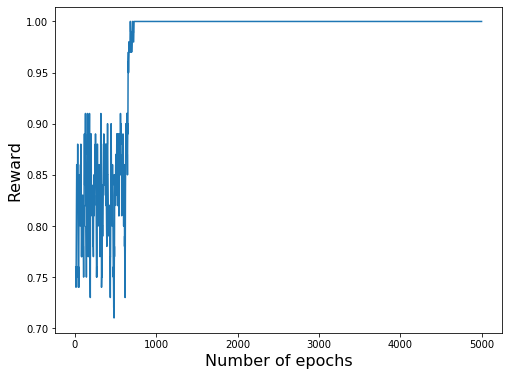

In [21]:
moving_average = True
average_window = 10

if moving_average:
    n_epochs = np.arange(average_window, len(score))
else:
    n_epochs = np.arange(len(score))

### plot score ###
plt.figure(figsize=(8,6))

if moving_average:
    average_score = np.array([np.mean(score[i:i+average_window]) for i in range(len(n_epochs))])
    plt.plot(n_epochs, average_score)
else:
    plt.plot(n_epochs, score)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Reward", fontsize=16)
plt.show()

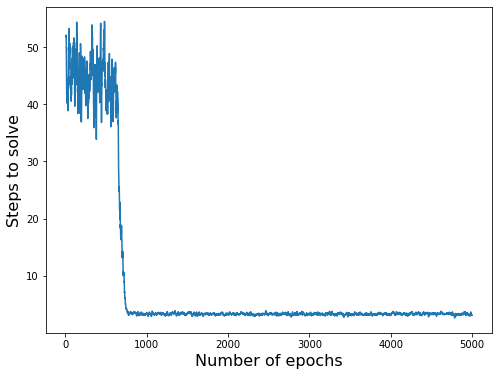

In [22]:
### steps to solve ###
plt.figure(figsize=(8,6))

if moving_average:
    average_score = np.array([np.mean(steps_to_solve[i:i+average_window]) for i in range(len(n_epochs))])
    plt.plot(n_epochs, average_score)
else:
    plt.plot(n_epochs, steps_to_solve)
plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Steps to solve", fontsize=16)
plt.show()

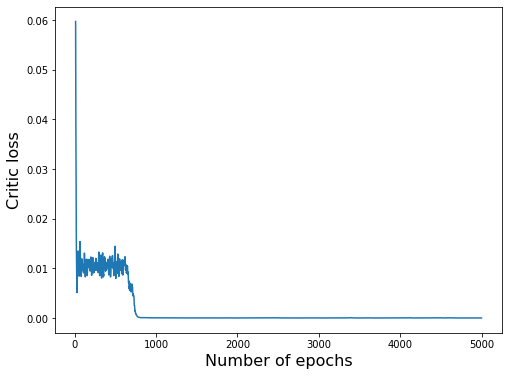

In [23]:
if moving_average:
    n_epochs = np.arange(average_window, len(losses['critic_losses']))
else:
    n_epochs = np.arange(len(losses['critic_losses']))

plt.figure(figsize=(8,6))

if moving_average:
    average_score = np.array([np.mean(losses['critic_losses'][i:i+average_window]) for i in range(len(n_epochs))])
    plt.plot(n_epochs, average_score)
else:
    plt.plot(n_epochs, losses['critic_losses'])

plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Critic loss", fontsize=16)
plt.show()


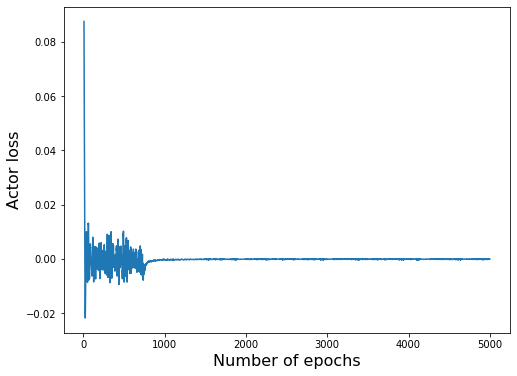

In [24]:
### plot actor loss ###
plt.figure(figsize=(8,6))

if moving_average:
    average_score = np.array([np.mean(losses['actor_losses'][i:i+average_window]) for i in range(len(n_epochs))])
    plt.plot(n_epochs, average_score)
else:
    plt.plot(n_epochs, losses['actor_losses'])

plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Actor loss", fontsize=16)
plt.show()
    
    

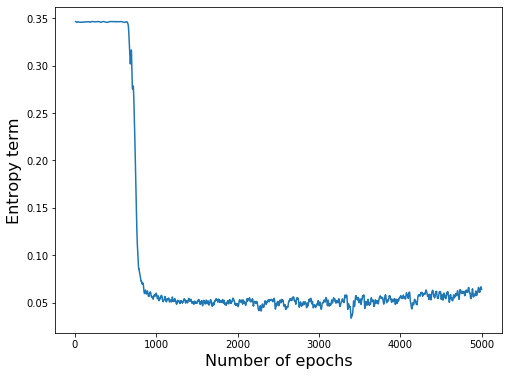

In [25]:
### plot entropy ###
plt.figure(figsize=(8,6))

if moving_average:
    average_score = np.array([np.mean(losses['entropies'][i:i+average_window]) for i in range(len(n_epochs))])
    plt.plot(n_epochs, -average_score)
else:
    plt.plot(n_epochs, -np.array(losses['entropies']))

plt.xlabel("Number of epochs", fontsize=16)
plt.ylabel("Entropy term", fontsize=16)
plt.show()

### Line by line

In [6]:
envs = ParallelEnv(n_train_processes, game_params)

In [7]:
optimizer = torch.optim.Adam(agent.parameters(), lr=lr)

step_idx = 0
s = envs.reset()
print("s.shape: ", s.shape)

s.shape:  (2, 3, 7, 7)


In [8]:
a, log_prob, probs = agent.get_action(s)

state.shape:  torch.Size([2, 3, 7, 7])
log_probs.shape:  torch.Size([2, 4])
log_probs:  tensor([[-1.3219, -1.3924, -1.4669, -1.3694],
        [-1.3226, -1.3941, -1.4677, -1.3663]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward>)
action.shape:  torch.Size([2])


In [9]:
s_prime, r, done, info, bootstrap, s_trg = envs.step(a)

In [10]:
print("s_prime.shape: ", s_prime.shape)
print("r.shape: ", r.shape)
print("r: ", r)
print("done.shape: ", done.shape)
print("done: ", done)
print("bootstrap.shape: ", bootstrap.shape)
print("bootstrap: ", bootstrap)
print("s_trg.shape: ", s_trg.shape)

s_prime.shape:  (2, 3, 7, 7)
r.shape:  (2,)
r:  [0 0]
done.shape:  (2,)
done:  [False False]
bootstrap.shape:  (2,)
bootstrap:  [False False]
s_trg.shape:  (2, 3, 7, 7)


In [8]:
import numpy as np

In [30]:
done = np.array([0,0,0,1,0,1])
rewards = done
T = len(done)

In [31]:
not_zero = np.nonzero(done)
episode_mask = []
last = -1

for x in not_zero[0]:
    m = [1 if (i > last and i <= x) else 0 for i in range(T)]
    for _ in range(x-last):
        episode_mask.append(m)
    last = x
episode_mask = np.array(episode_mask)

In [32]:
episode_mask

array([[1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 1, 1]])

In [33]:
n_steps_mask = []
n = 3
for i in range(T):
    m = [1 if (j>=i and j<i+n) else 0 for j in range(T)]
    n_steps_mask.append(m)
n_steps_mask = np.array(n_steps_mask)

In [34]:
n_steps_mask

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 1, 0],
       [0, 0, 0, 1, 1, 1],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [17]:
episode_mask*n_steps_mask

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [14]:
gamma = 0.99
Gamma = np.array([gamma**i for i in range(T)])

In [18]:
episode_mask*n_steps_mask*Gamma

array([[1.        , 0.99      , 0.9801    , 0.        , 0.        ,
        0.        ],
       [0.        , 0.99      , 0.9801    , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.9801    , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.96059601,
        0.95099005],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.95099005]])

In [22]:
rewards_tiled = np.concatenate([rewards.reshape(1,-1) for _ in range(len(rewards))], axis=0)

In [23]:
rewards_tiled

array([[0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1],
       [0, 0, 0, 1, 0, 1]])

In [24]:
episode_mask*n_steps_mask*Gamma*rewards_tiled

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.970299  , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.95099005],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.95099005]])

In [27]:
tot_G = (rewards_tiled*episode_mask*n_steps_mask*Gamma).sum(axis=1)/Gamma
tot_G

array([0.    , 0.9801, 0.99  , 1.    , 0.99  , 1.    ])

### Introducing batch dim

In [26]:
done = np.array([[0,0,0,0,0,0],
                 [0,0,1,0,0,1]])
rewards = done
B = done.shape[0]
T = done.shape[1]
n = 3

In [27]:
xs, ys = np.nonzero(done)
xs = np.concatenate([xs, np.arange(B)])
ys = np.concatenate([ys, np.full(B, T-1)])

In [28]:
ys

array([2, 5, 5, 5])

In [1]:
episode_mask = [[] for _ in range(B)]
last = [-1 for _ in range(B)]

for x, y in zip(xs, ys):
    m = [1 if (i > last[x] and i <= y) else 0 for i in range(T)]
    for _ in range(y-last[x]):
        episode_mask[x].append(m)
    last[x] = y
episode_mask = np.array(episode_mask)

NameError: name 'B' is not defined

In [30]:
episode_mask.shape

(2, 6, 6)

In [36]:
n_steps_mask = []
for i in range(T):
    m = [1 if (j>=i and j<i+n) else 0 for j in range(T)]
    n_steps_mask.append(m)
n_steps_mask = np.array(n_steps_mask)

In [39]:
n_steps_mask_b = np.repeat(n_steps_mask[np.newaxis,...] , B, axis=0) # this is always the same for each batch
n_steps_mask_b.shape

(2, 6, 6)

In [59]:
rewards_repeated = np.repeat(rewards[:,np.newaxis,:], T, axis=1)
rewards_repeated.shape

(2, 6, 6)

In [60]:
gamma = 0.99
Gamma = np.array([gamma**i for i in range(T)]).reshape(1,-1)
Gamma.shape

(1, 6)

In [61]:
rewards_repeated

array([[[0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1],
        [0, 0, 0, 1, 0, 1]],

       [[0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1],
        [0, 0, 1, 0, 0, 1]]])

In [67]:
G = (Gamma*rewards_repeated*episode_mask*n_steps_mask_b).sum(axis=2)/Gamma

In [68]:
G

array([[0.    , 0.9801, 0.99  , 1.    , 0.99  , 1.    ],
       [0.9801, 0.99  , 1.    , 0.9801, 0.99  , 1.    ]])

### n-steps target state

In [186]:
done = np.array([0,0,0,1,0,1])
T = len(done)
n = 3
s = np.array(['s'+str(i) for i in range(T)])
s_trg = np.array(['s_t'+str(i) for i in range(T)])

In [187]:
not_zero = np.nonzero(done)
episode_mask = []
last = -1

for x in not_zero[0]:
    m = [1 if (i > last and i <= x) else 0 for i in range(T)]
    for _ in range(x-last):
        episode_mask.append(m)
    last = x
episode_mask = np.array(episode_mask)

In [188]:
n_steps_mask = []
n = 3
for i in range(T):
    m = [1 if (j>=i and j<i+n) else 0 for j in range(T)]
    n_steps_mask.append(m)
n_steps_mask = np.array(n_steps_mask)

In [189]:
V_mask = episode_mask*n_steps_mask
V_mask

array([[1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0],
       [0, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 1]])

In [190]:
x, y = np.nonzero(V_mask)

In [191]:
V_trg_index = []
for i in range(T):
    V_trg_index.append(y[x==i][-1])
V_trg_index = np.array(V_trg_index)

In [192]:
s_trg[V_trg_index]

array(['s_t2', 's_t3', 's_t3', 's_t3', 's_t5', 's_t5'], dtype='<U4')

Now we also need to compute the corresponding gamma

In [193]:
V_trg_index

array([2, 3, 3, 3, 5, 5])

In [194]:
pw = V_trg_index - np.arange(V_trg_index.shape[0]) + 1

In [195]:
pw

array([3, 3, 2, 1, 2, 1])

Finally we also need to update done

In [197]:
shifted_done = done[V_trg_index]
shifted_done

array([0, 1, 1, 1, 1, 1])

### Adding batch dim

In [12]:
done = np.array([[0,0,0,1,0,1],
                 [0,0,1,0,0,1]])
B = done.shape[0]
T = done.shape[1]
n = 2
s = np.array([['s0,'+str(i) for i in range(T)],['s1,'+str(i) for i in range(T)]] )
s_trg = np.array([['s_t0,'+str(i) for i in range(T)],['s_t1,'+str(i) for i in range(T)]] )

In [13]:
s

array([['s0,0', 's0,1', 's0,2', 's0,3', 's0,4', 's0,5'],
       ['s1,0', 's1,1', 's1,2', 's1,3', 's1,4', 's1,5']], dtype='<U4')

In [14]:
not_zero = np.nonzero(done)
episode_mask = [[] for _ in range(B)]
last = [-1 for _ in range(B)]

for x, y in zip(*not_zero):
    m = [1 if (i > last[x] and i <= y) else 0 for i in range(T)]
    for _ in range(y-last[x]):
        episode_mask[x].append(m)
    last[x] = y
episode_mask = np.array(episode_mask)

In [15]:
n_steps_mask = []
for i in range(T):
    m = [1 if (j>=i and j<i+n) else 0 for j in range(T)]
    n_steps_mask.append(m)
n_steps_mask = np.array(n_steps_mask)
n_steps_mask_b = np.repeat(n_steps_mask[np.newaxis,...] , B, axis=0)

In [16]:
V_mask = episode_mask*n_steps_mask_b

In [17]:
b, x, y = np.nonzero(V_mask)

In [18]:
b

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [19]:
x

array([0, 0, 1, 1, 2, 2, 3, 4, 4, 5, 0, 0, 1, 1, 2, 3, 3, 4, 4, 5])

In [20]:
y

array([0, 1, 1, 2, 2, 3, 3, 4, 5, 5, 0, 1, 1, 2, 2, 3, 4, 4, 5, 5])

In [21]:
V_trg_index = [[] for _ in range(B)]
for b_i in range(B):
    valid_x = (b==b_i)
    for i in range(T):
        matching_x = (x==i)
        V_trg_index[b_i].append(y[valid_x*matching_x][-1])

In [22]:
V_trg_index = np.array(V_trg_index)
V_trg_index

array([[1, 2, 3, 3, 5, 5],
       [1, 2, 2, 4, 5, 5]])

In [23]:
cols = np.array([], dtype=np.int)
rows = np.array([], dtype=np.int)
for i, v in enumerate(V_trg_index):
    cols = np.concatenate([cols, v], axis=0)
    row = np.full(V_trg_index.shape[1], i)
    rows = np.concatenate([rows, row], axis=0)

In [24]:
V_trg_index.shape

(2, 6)

In [25]:
s_trg.shape

(2, 6)

In [27]:
help(s_trg.transpose)

Help on built-in function transpose:

transpose(...) method of numpy.ndarray instance
    a.transpose(*axes)
    
    Returns a view of the array with axes transposed.
    
    For a 1-D array this has no effect, as a transposed vector is simply the
    same vector. To convert a 1-D array into a 2D column vector, an additional
    dimension must be added. `np.atleast2d(a).T` achieves this, as does
    `a[:, np.newaxis]`.
    For a 2-D array, this is a standard matrix transpose.
    For an n-D array, if axes are given, their order indicates how the
    axes are permuted (see Examples). If axes are not provided and
    ``a.shape = (i[0], i[1], ... i[n-2], i[n-1])``, then
    ``a.transpose().shape = (i[n-1], i[n-2], ... i[1], i[0])``.
    
    Parameters
    ----------
    axes : None, tuple of ints, or `n` ints
    
     * None or no argument: reverses the order of the axes.
    
     * tuple of ints: `i` in the `j`-th place in the tuple means `a`'s
       `i`-th axis becomes `a.transpos

In [233]:
rows

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [234]:
cols

array([1, 2, 3, 3, 5, 5, 1, 2, 2, 4, 5, 5])

In [235]:
n_step_s_trg = s_trg[rows, cols]

In [236]:
pw = V_trg_index - np.arange(V_trg_index.shape[1]) + 1

In [237]:
pw

array([[2, 2, 2, 1, 2, 1],
       [2, 2, 1, 2, 2, 1]])

In [239]:
Gamma_V = gamma**pw

In [238]:
shifted_done = done[rows, cols]
shifted_done

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1])